# **Pretrain a TF model to imitate federated learning**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import json

In [4]:
RESULTS_ROOT = "../01_simulation/04_results/"
SEEDS = ['42', '1234', '1867', '613', '1001']

In [5]:
p_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = RESULTS_ROOT+f'poccup_by_vehs_{s}.csv'
    pf = pd.read_csv(filename)
    pf["seed"] = [s]*len(pf)
    p_data = pd.concat([p_data, pf])
    

In [6]:
def combine_commuters(veh_id):
    if veh_id.startswith("carIn"):
        return veh_id.split(":")[0]
    return veh_id

In [7]:
p_data["veh_id"] = p_data["veh_id"].apply(combine_commuters)

In [8]:
len(p_data["veh_id"].unique())

4644

In [9]:
parkings = p_data["parking_id"].unique()

In [10]:
p_data = pd.get_dummies(p_data, columns=["parking_id"])
p_data["time"] = p_data["time"] - 4*24*60*60
p_data["time"] = p_data["time"].astype(int)
p_data["time_of_day"] = (p_data["time"] - (p_data["time"] // (24*60*60))*24*60*60) / (24*60*60) #converting to 0.0-1.0 and removing periodicity

In [11]:
column_dict = {}
for_columns_data = p_data.head()
for_columns_data = for_columns_data.drop(columns=["veh_id", "time", "occupancy", "seed", "occupancy"])
cols = list(for_columns_data.columns)
for p in parkings:
    column_dict[p] = cols.index(f"parking_id_{p}")

In [12]:
with open("one_hot_encoding_dict.json", "w") as f:
    json.dump(column_dict, f)

## Create vehicle list

In [13]:
vehicles = np.random.choice(p_data["veh_id"].unique(), 4300, replace=False) #out of 4644 vehicles
test_vehicles = np.random.choice(p_data[~p_data["veh_id"].isin(vehicles)]["veh_id"].unique(), 300, replace=False)

In [14]:
# save the list of selected vehicles:
import json

save_vehs = {
    "train_vehs": list(vehicles),
    "test_vehs" : list(test_vehicles)
}
with open("veh_list.json", "w") as f:
    json.dump(save_vehs, f)

## Load vehicle list

In [13]:
#loading the list selected vehicles:
with open("veh_list.json", "r") as f:
    saved_vehs = json.load(f)
vehicles = saved_vehs["train_vehs"]

## Training

In [14]:
p_train = p_data[p_data["veh_id"].isin(vehicles)]

In [15]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001))
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)]

2024-05-07 16:10:09.164661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 16:10:09.177782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 16:10:09.177953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 16:10:09.178701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
X_train = p_train.drop(columns=["veh_id", "time", "occupancy", "seed"])
y_train = p_train["occupancy"]

In [17]:
train_indices = np.random.randint(0, len(X_train), 1000000)
x_train_batch = X_train.iloc[train_indices]
y_train_batch = y_train.iloc[train_indices]
history = model.fit(x=x_train_batch, y=y_train_batch, epochs=5, batch_size=10000, callbacks=callbacks)
while len(history.history["loss"])%5 == 0:
    history = model.fit(x=x_train_batch, y=y_train_batch, epochs=5, batch_size=10000, callbacks=callbacks)

Epoch 1/5
 46/100 [============>.................] - ETA: 0s - loss: 0.1168

2024-05-07 16:10:11.147046: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 1s 2ms/step - loss: 0.0808
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0374
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 1/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 3/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 4/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 5/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 1/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 2/5
100/100 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 3/5
100/100 [==============================]

## **Checking**

In [18]:
p_data

,veh_id,time,occupancy,seed,parking_id_pa-109,parking_id_pa-11,parking_id_pa-120,parking_id_pa-123,parking_id_pa-131,parking_id_pa-144,...,parking_id_pa55,parking_id_pa58,parking_id_pa60,parking_id_pa64,parking_id_pa68,parking_id_pa71,parking_id_pa75,parking_id_pa79,parking_id_pa92,time_of_day
0,h3098c1:0,10,0.923077,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000116
1,h3098c1:0,10,0.842105,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000116
2,h3098c1:0,10,0.769231,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000116
3,h3098c1:0,11,0.923077,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000127
4,h3098c1:0,11,0.842105,42,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128768,h798c1:0,432000,0.000000,1001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3128769,h798c1:0,432000,0.750000,1001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3128770,h3101c1:0,432000,0.428571,1001,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3128771,h3101c1:0,432000,0.000000,1001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [19]:
#PARKING = "pa184"
PARKING = "pa-71"

In [40]:
parking_data = p_data[p_data[f"parking_id_{PARKING}"] == 1]
vis_data_mean = parking_data.groupby("time_of_day")["occupancy"].mean()
vis_data_std = parking_data.groupby("time_of_day")["occupancy"].std().fillna(0)

In [21]:
t = np.arange(0, 1, 1/(24*60*60))

In [22]:
one_hot = parking_data.drop(columns=["veh_id", "time", "occupancy", "seed", "time_of_day"]).iloc[0]
one_hot = [one_hot.values]*len(t)

In [23]:
pred_x = np.array(one_hot)

In [24]:
pred_x = pd.DataFrame(pred_x)
pred_x["t"] = t

In [49]:
preds = model.predict(pred_x, batch_size=200)

432/432 [==============================] - 0s 687us/step


In [42]:
len(vis_data_mean)

63110

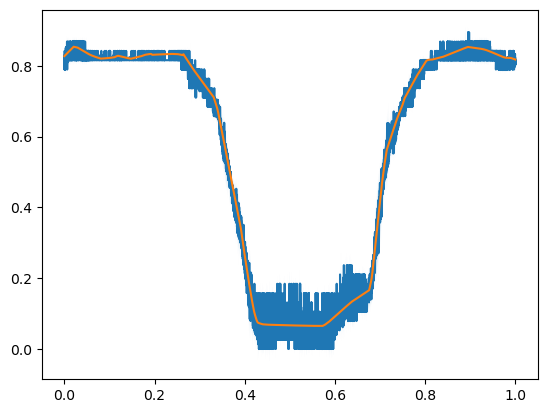

In [45]:
plt.plot(vis_data_mean)
plt.fill_between(vis_data_mean.index, vis_data_std+vis_data_mean, vis_data_mean-vis_data_std, alpha=0.3)
plt.plot(t, preds)

In [56]:
times, meas_mean, meas_std, pred_sampled = [], [], [], []
for tx in range(0, 24*60*60, 600):
    t = tx/(24*60*60)
    times.append(t)
    
    meas = parking_data[parking_data["time_of_day"] >= t]
    meas = meas[meas["time_of_day"] < t+600/(24*60*60)]
    meas_mean.append(meas["occupancy"].mean())
    meas_std.append(meas["occupancy"].std())
    
    pred_sampled.append(preds[tx])

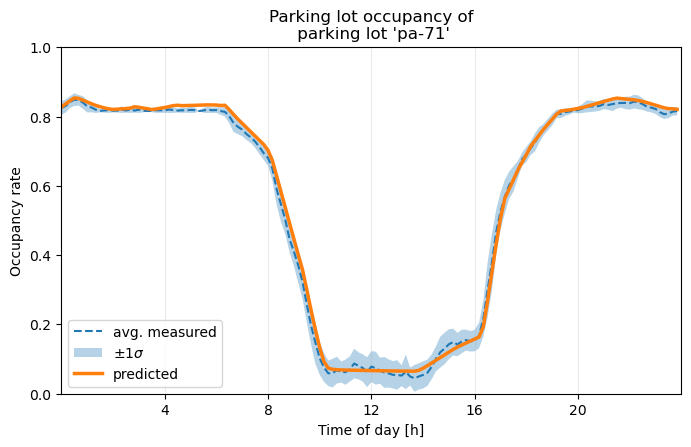

In [76]:
times = np.array(times)
meas_mean = np.array(meas_mean)
meas_std = np.array(meas_std)
pred_sampled = np.array(pred_sampled)

plt.figure(figsize=(8, 4.5))
plt.plot(times*24, meas_mean, "--", label="avg. measured")
plt.fill_between(times*24, meas_mean-meas_std, meas_mean+meas_std, alpha=0.33, label="$\pm 1 \sigma$")
plt.plot(times*24, pred_sampled, label="predicted", linewidth=2.5)
plt.xlim(0, 24)
plt.ylim(0, 1)
plt.xticks([4, 8, 12, 16, 20])
plt.grid(visible=True, which='major', axis='x', alpha=0.25)
plt.title(f"Parking lot occupancy of\n parking lot '{PARKING}'")
plt.ylabel("Occupancy rate")
plt.xlabel("Time of day [h]")
plt.legend()

In [30]:
model.save("saved_models/pretrained")

INFO:tensorflow:Assets written to: saved_models/pretrained/assets
